## 0. Goal
Run VAE first to reduce spectrogram dimensions from 128*128 to 32 latent features. Then run UMAP and HDBSCAN. <br>
Use Goffinet spectrogramming and VAE network. <br>
Differ from v2: try different parameters for UMAP and HDBSCAN. Assume VAE has been trained.

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import calinski_harabasz_score

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import hopkins2
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)
importlib.reload(hopkins2)

<module 'hopkins2' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/hopkins2.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [7]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdIDs = ['pair5RigCCU29', 'pair4RigACU68', 'pair4RigBCU53', 'pair2RigBCU25']
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [[1.5,7], [1.5,7], [1.5,8.5], [1.5,8]]
# what syllable to analyze
syl = ['v']
sylStr = ''.join(syl)
# the default color list
col_list = ['#e41a1c','#a65628','#4daf4a','#984ea3','#ff7f00','#f781bf','#377eb8','#737373']
# what input dataset to use: real and matched shuffle
input_rn = 'spec_goffinet_nn_256_176'
# size of the spectrogram windows
X_SHAPE = [128, 128]

In [8]:
# parameters to vary
umap_metric = ['euclidean', 'cosine', 'correlation']
hdbscan_selection = ['eom', 'leaf']
hdbscan_min_cluster = [0.05, 0.02]

In [9]:
# fixed paramteres for UMAP and HDBSCAN
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0}
param_hdbscan = {'min_cluster_size_frac':0.05, 'min_samples': 20}

## 2. Loop through birds: VAE -> UMAP -> HDBSCAN

In [25]:
# save metrics in a master dataframe
metrics = pd.DataFrame()

Save results to /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigACU68/UMAPonVAE2/v
(36359, 32) (36359, 7)
{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0}
euclidean_eom_0.05
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Mon Jun  9 17:28:12 2025 Construct fuzzy simplicial set
Mon Jun  9 17:28:12 2025 Finding Nearest Neighbors
Mon Jun  9 17:28:12 2025 Building RP forest with 15 trees
Mon Jun  9 17:28:12 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 17:28:14 2025 Finished Nearest Neighbor Search
Mon Jun  9 17:28:14 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 17:28:29 2025 Finished embedding
The fraction that are not clustered: 0.1887
Total number of clusters: 6
Hopkins metric in UMAP: 0.9838
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: 0.3620
HDBSCAN Silhouette score in VAE: 0.0134
Calinski–Harabasz index in UMAP: 18939.5378
Calinski–Harabasz index in VAE: 1498.1977
The fraction that are not clustered: 0.1134
Total number of clusters: 14
Hopkins metric in UMAP: 0.9838
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: 0.3522
HDBSCAN Silhouette score in VAE: 0.0132
Calinski–Harabasz index in UMAP: 23219.0562
Calinski–Harabasz index in VAE: 997.6981
The fraction that are not clustered: 0.2427
Total nu

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 17:30:37 2025 Finished Nearest Neighbor Search
Mon Jun  9 17:30:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 17:30:51 2025 Finished embedding
The fraction that are not clustered: 0.0299
Total number of clusters: 2
Hopkins metric in UMAP: 0.9819
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: 0.2802
HDBSCAN Silhouette score in VAE: -0.0514
Calinski–Harabasz index in UMAP: 6204.6443
Calinski–Harabasz index in VAE: 907.3947
The fraction that are not clustered: 0.0000
Total number of clusters: 4
Hopkins metric in UMAP: 0.9819
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: 0.2317
HDBSCAN Silhouette score in VAE: -0.0746
Calinski–Harabasz index in UMAP: 4148.7030
Calinski–Harabasz index in VAE: 669.4367
The fraction that are not clustered: 0.2174
Total numb

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 17:33:05 2025 Finished Nearest Neighbor Search
Mon Jun  9 17:33:05 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 17:33:19 2025 Finished embedding
The fraction that are not clustered: 0.0464
Total number of clusters: 3
Hopkins metric in UMAP: 0.9842
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: 0.3413
HDBSCAN Silhouette score in VAE: -0.0139
Calinski–Harabasz index in UMAP: 15317.4398
Calinski–Harabasz index in VAE: 1343.4314
The fraction that are not clustered: 0.1586
Total number of clusters: 13
Hopkins metric in UMAP: 0.9842
Hopkins metric in VAE: 0.8502
HDBSCAN Silhouette score in UMAP: 0.3721
HDBSCAN Silhouette score in VAE: 0.0143
Calinski–Harabasz index in UMAP: 31275.3931
Calinski–Harabasz index in VAE: 1121.5514
The fraction that are not clustered: 0.3437
Total 

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 17:35:27 2025 Finished Nearest Neighbor Search
Mon Jun  9 17:35:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 17:35:34 2025 Finished embedding
The fraction that are not clustered: 0.2039
Total number of clusters: 5
Hopkins metric in UMAP: 0.9697
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.3090
HDBSCAN Silhouette score in VAE: -0.0018
Calinski–Harabasz index in UMAP: 7289.8932
Calinski–Harabasz index in VAE: 601.1207
The fraction that are not clustered: 0.1443
Total number of clusters: 8
Hopkins metric in UMAP: 0.9697
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.3060
HDBSCAN Silhouette score in VAE: -0.0130
Calinski–Harabasz index in UMAP: 6894.6465
Calinski–Harabasz index in VAE: 492.0220
The fraction that are not clustered: 0.3583
Total numb

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 17:36:05 2025 Finished Nearest Neighbor Search
Mon Jun  9 17:36:05 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 17:36:12 2025 Finished embedding
The fraction that are not clustered: 0.0177
Total number of clusters: 4
Hopkins metric in UMAP: 0.9754
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.3649
HDBSCAN Silhouette score in VAE: -0.0049
Calinski–Harabasz index in UMAP: 10788.2744
Calinski–Harabasz index in VAE: 603.8243
The fraction that are not clustered: 0.1431
Total number of clusters: 15
Hopkins metric in UMAP: 0.9754
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.3757
HDBSCAN Silhouette score in VAE: 0.0237
Calinski–Harabasz index in UMAP: 10796.2844
Calinski–Harabasz index in VAE: 440.2343
The fraction that are not clustered: 0.2129
Total nu

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 17:36:42 2025 Finished Nearest Neighbor Search
Mon Jun  9 17:36:42 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 17:36:49 2025 Finished embedding
The fraction that are not clustered: 0.0172
Total number of clusters: 4


/tmp/ipykernel_232603/3597830521.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])


Hopkins metric in UMAP: 0.9748
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.3829
HDBSCAN Silhouette score in VAE: -0.0081
Calinski–Harabasz index in UMAP: 10554.6144
Calinski–Harabasz index in VAE: 598.1937
The fraction that are not clustered: 0.0827
Total number of clusters: 13
Hopkins metric in UMAP: 0.9748
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.4543
HDBSCAN Silhouette score in VAE: 0.0284
Calinski–Harabasz index in UMAP: 12372.6059
Calinski–Harabasz index in VAE: 508.2389
The fraction that are not clustered: 0.2066
Total number of clusters: 9
Hopkins metric in UMAP: 0.9748
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.4182
HDBSCAN Silhouette score in VAE: 0.0149
Calinski–Harabasz index in UMAP: 13242.1122
Calinski–Harabasz index in VAE: 577.5610
The fraction that are not clustered: 0.2434
Total number of clusters: 19
Hopkins metric in UMAP: 0.9748
Hopkins metric in VAE: 0.8248
HDBSCAN Silhouette score in UMAP: 0.216

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 17:37:20 2025 Finished Nearest Neighbor Search
Mon Jun  9 17:37:20 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 17:37:27 2025 Finished embedding
The fraction that are not clustered: 0.0058
Total number of clusters: 3
Hopkins metric in UMAP: 0.9849
Hopkins metric in VAE: 0.8310
HDBSCAN Silhouette score in UMAP: 0.4503
HDBSCAN Silhouette score in VAE: 0.0325
Calinski–Harabasz index in UMAP: 14335.3560
Calinski–Harabasz index in VAE: 864.1092
The fraction that are not clustered: 0.0061
Total number of clusters: 4
Hopkins metric in UMAP: 0.9849
Hopkins metric in VAE: 0.8310
HDBSCAN Silhouette score in UMAP: 0.3836
HDBSCAN Silhouette score in VAE: 0.0215
Calinski–Harabasz index in UMAP: 12817.0354
Calinski–Harabasz index in VAE: 757.3726
The fraction that are not clustered: 0.1947
Total numb

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 17:37:59 2025 Finished Nearest Neighbor Search
Mon Jun  9 17:37:59 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 17:38:06 2025 Finished embedding
The fraction that are not clustered: 0.0118
Total number of clusters: 3
Hopkins metric in UMAP: 0.9834
Hopkins metric in VAE: 0.8310
HDBSCAN Silhouette score in UMAP: 0.3850
HDBSCAN Silhouette score in VAE: 0.0386
Calinski–Harabasz index in UMAP: 14482.8635
Calinski–Harabasz index in VAE: 871.5667
The fraction that are not clustered: 0.1279
Total number of clusters: 12
Hopkins metric in UMAP: 0.9834
Hopkins metric in VAE: 0.8310
HDBSCAN Silhouette score in UMAP: 0.4092
HDBSCAN Silhouette score in VAE: 0.0438
Calinski–Harabasz index in UMAP: 14117.8760
Calinski–Harabasz index in VAE: 676.9193
The fraction that are not clustered: 0.3066
Total num

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Mon Jun  9 17:38:38 2025 Finished Nearest Neighbor Search
Mon Jun  9 17:38:38 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun  9 17:38:45 2025 Finished embedding
The fraction that are not clustered: 0.0060
Total number of clusters: 3
Hopkins metric in UMAP: 0.9852
Hopkins metric in VAE: 0.8310
HDBSCAN Silhouette score in UMAP: 0.4087
HDBSCAN Silhouette score in VAE: 0.0296
Calinski–Harabasz index in UMAP: 14304.7569
Calinski–Harabasz index in VAE: 863.8998
The fraction that are not clustered: 0.0063
Total number of clusters: 4
Hopkins metric in UMAP: 0.9852
Hopkins metric in VAE: 0.8310
HDBSCAN Silhouette score in UMAP: 0.3571
HDBSCAN Silhouette score in VAE: -0.0194
Calinski–Harabasz index in UMAP: 11632.8418
Calinski–Harabasz index in VAE: 704.6828
The fraction that are not clustered: 0.3385
Total num

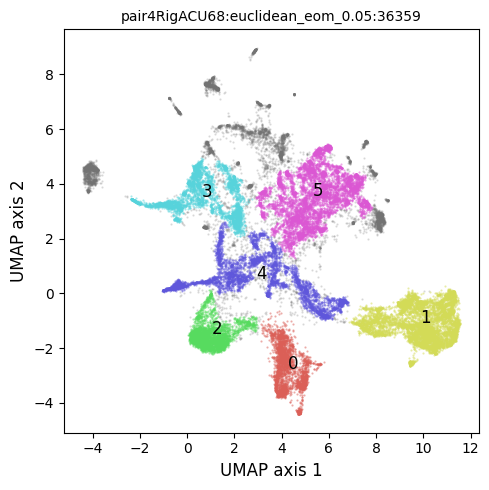

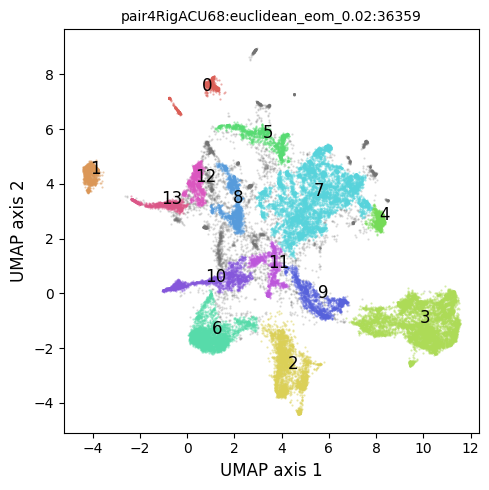

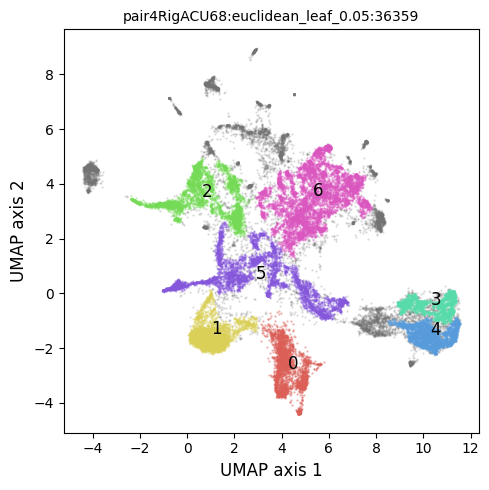

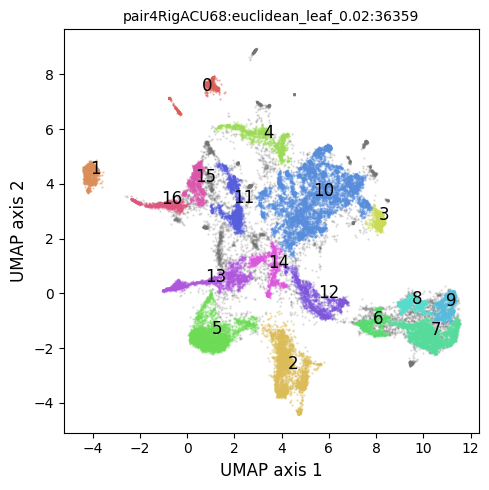

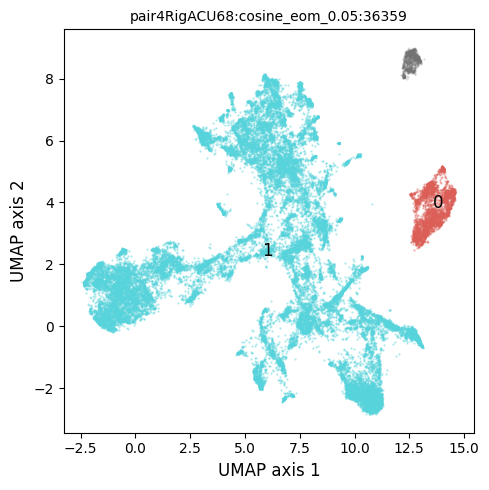

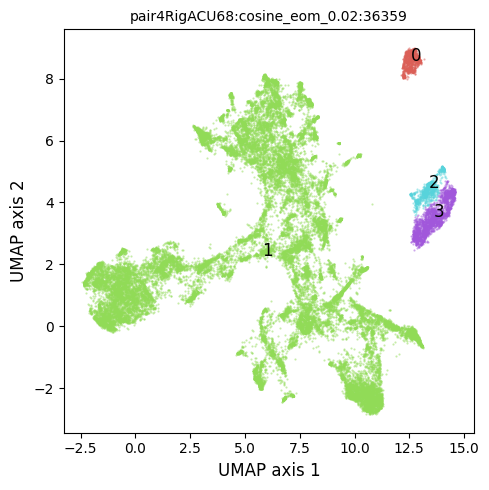

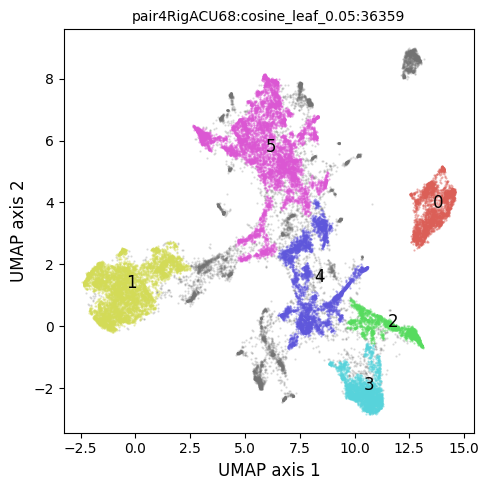

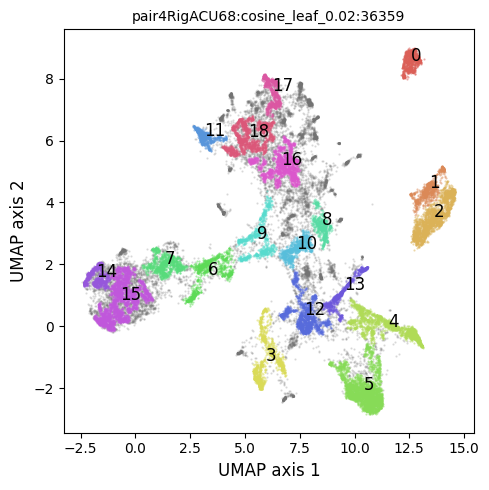

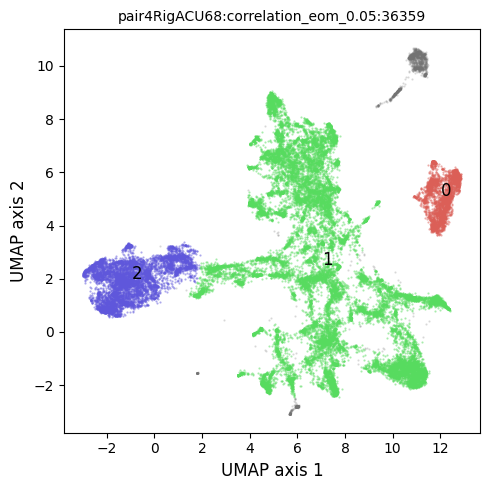

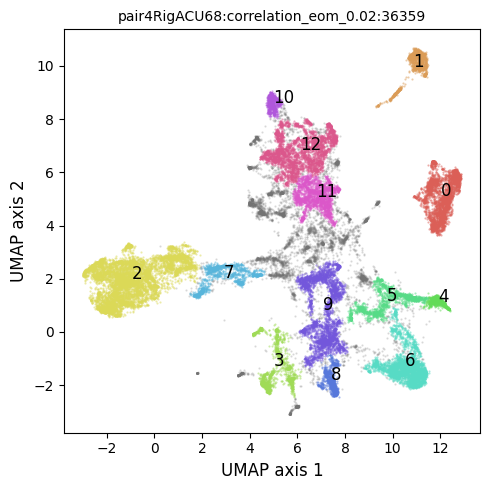

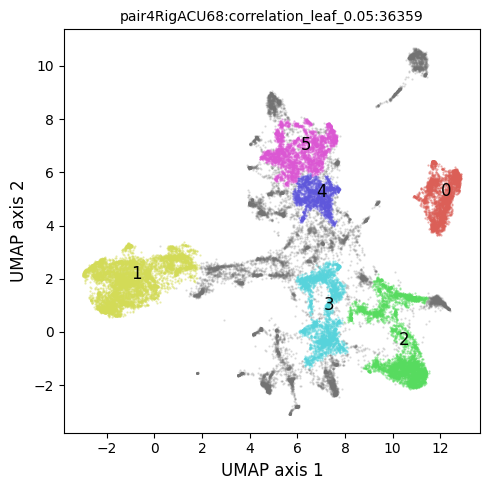

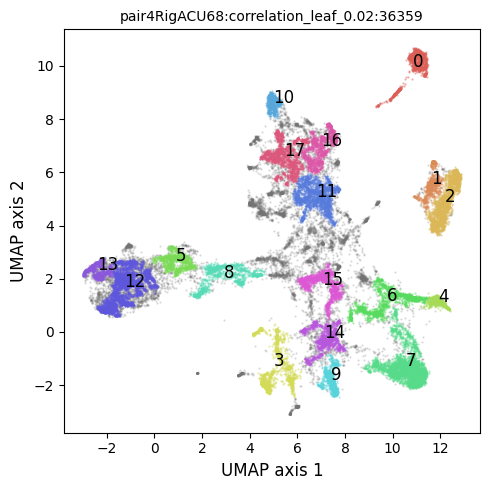

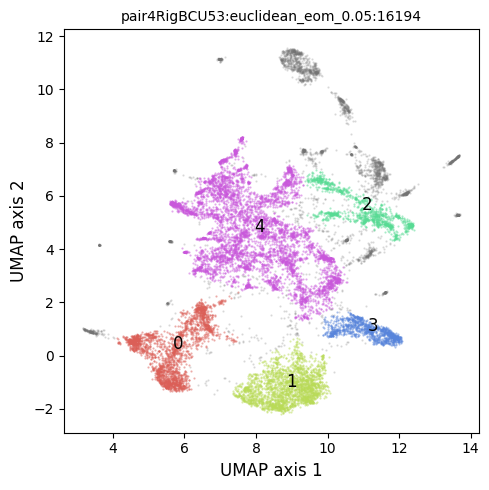

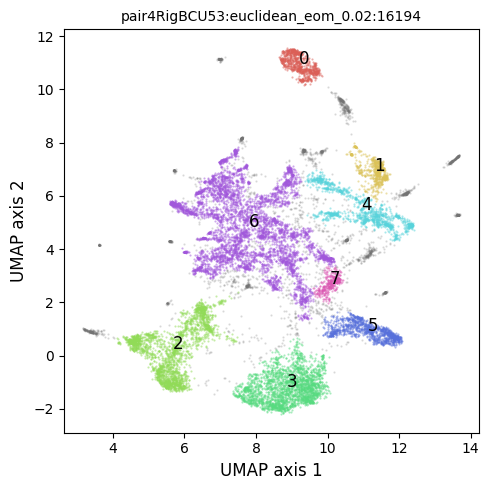

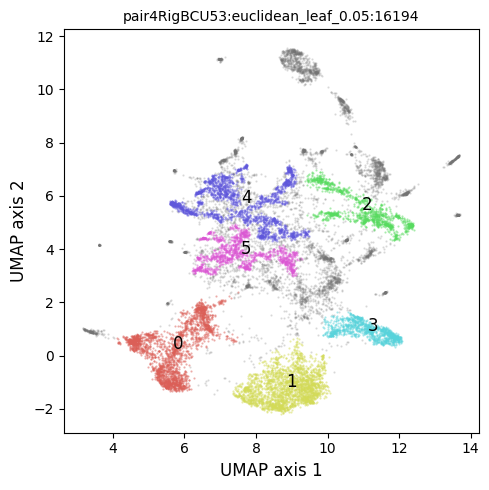

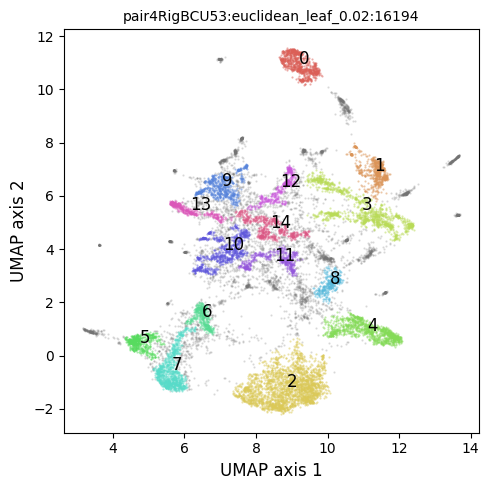

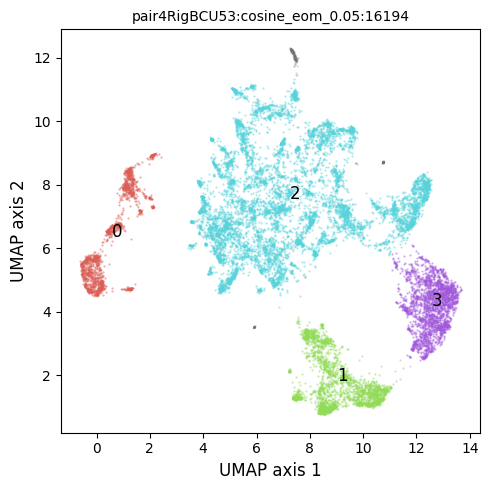

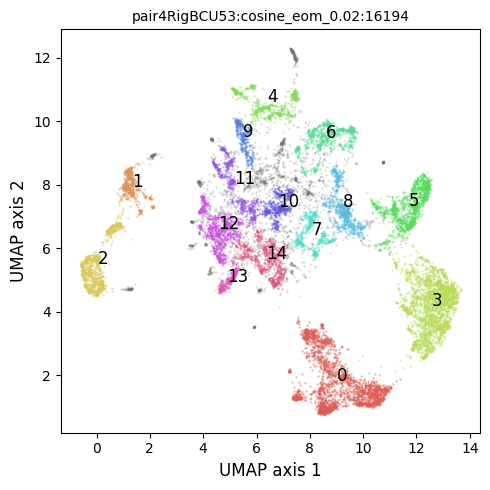

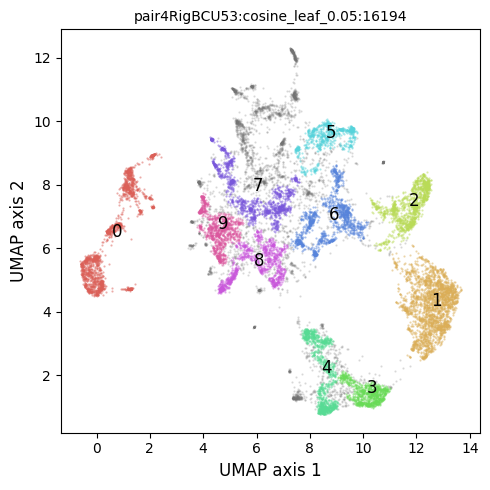

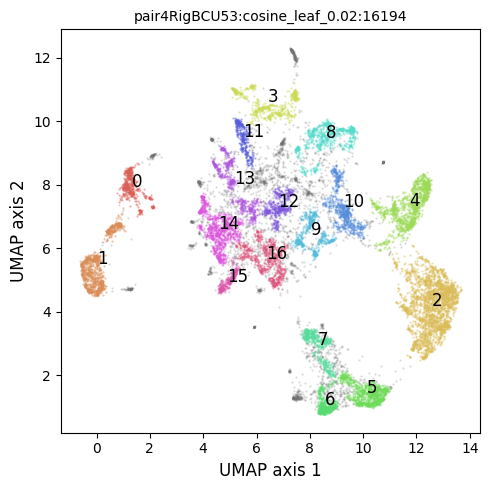

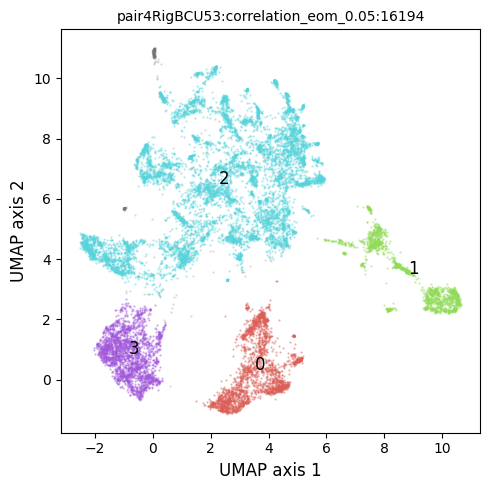

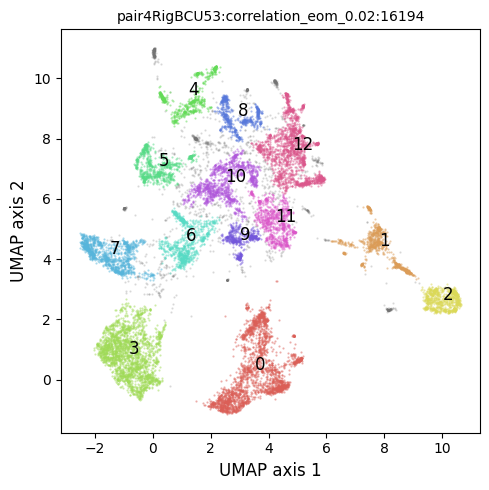

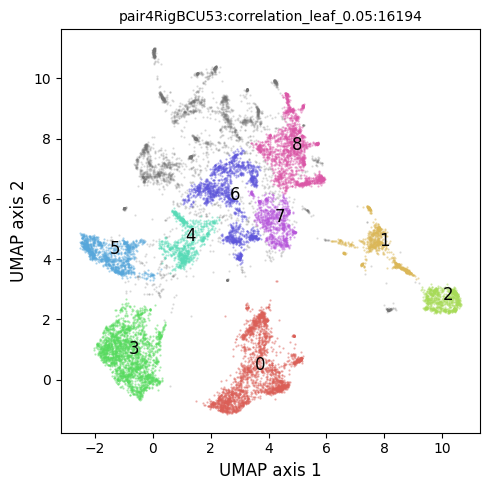

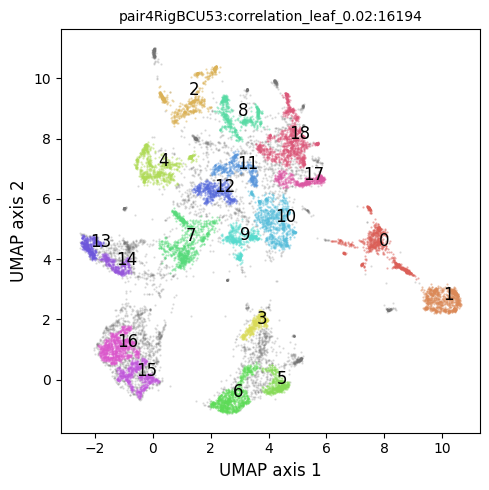

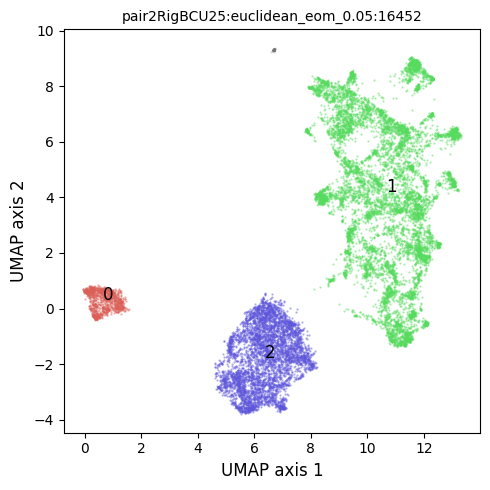

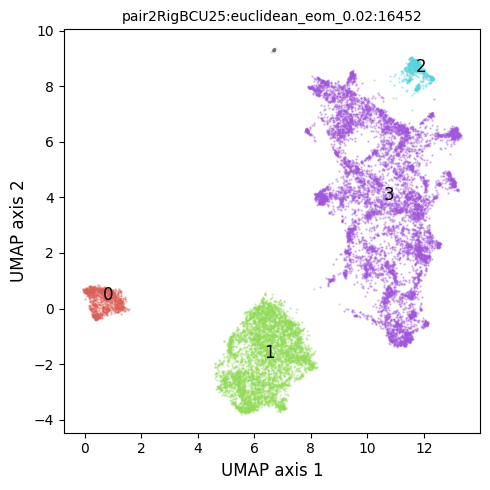

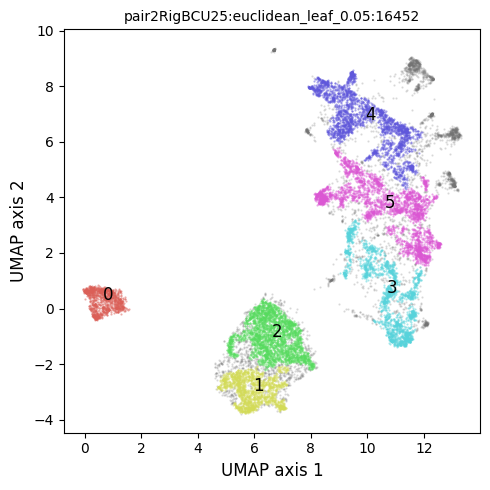

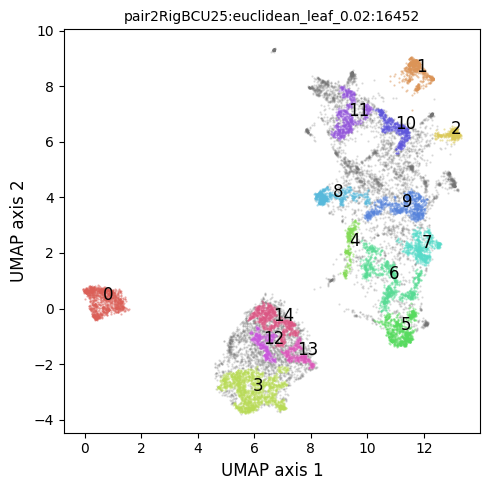

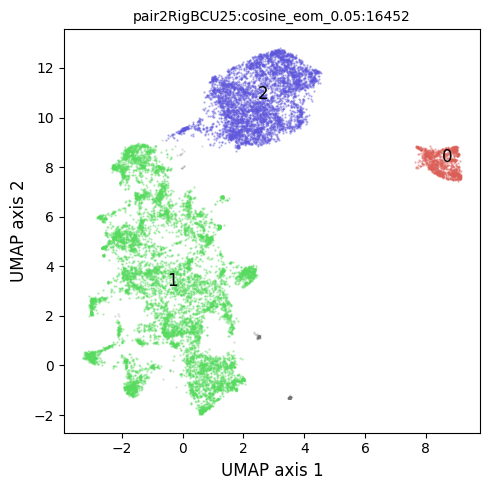

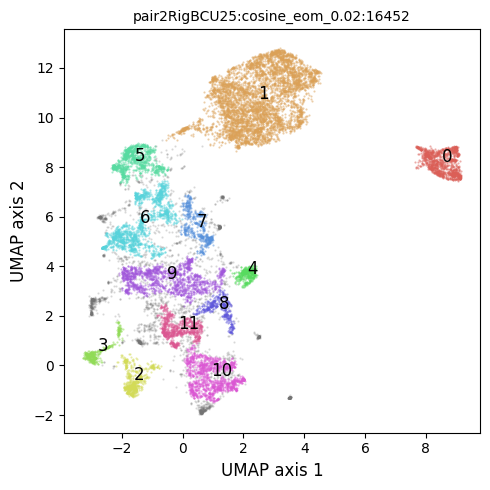

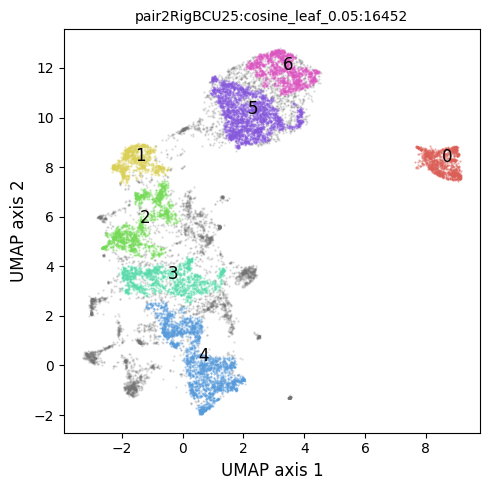

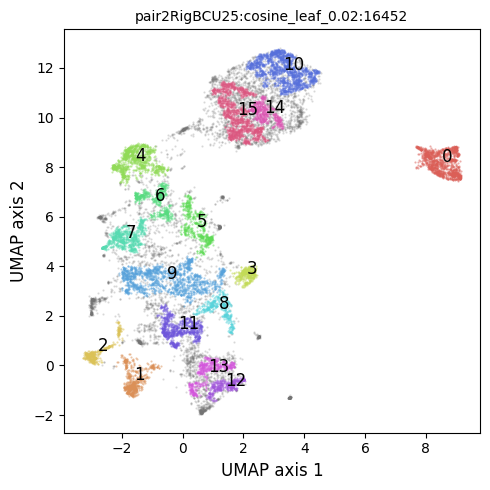

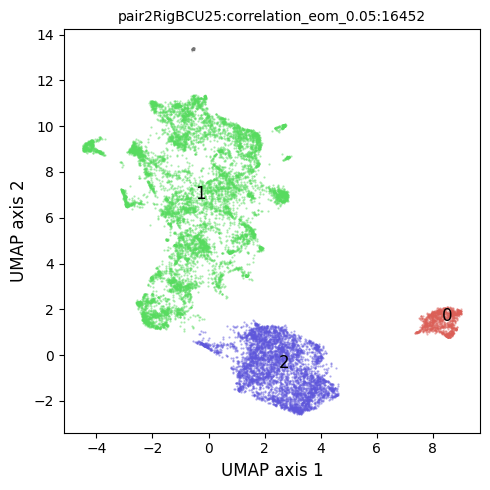

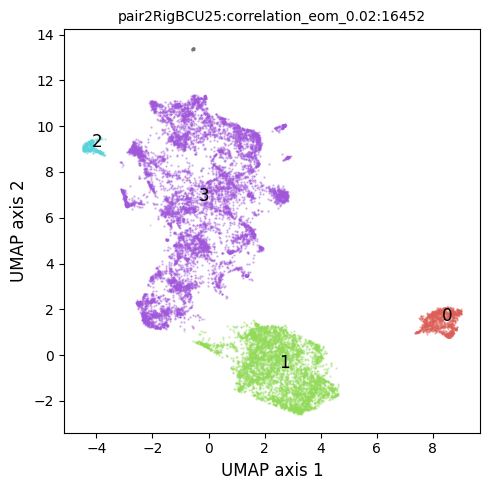

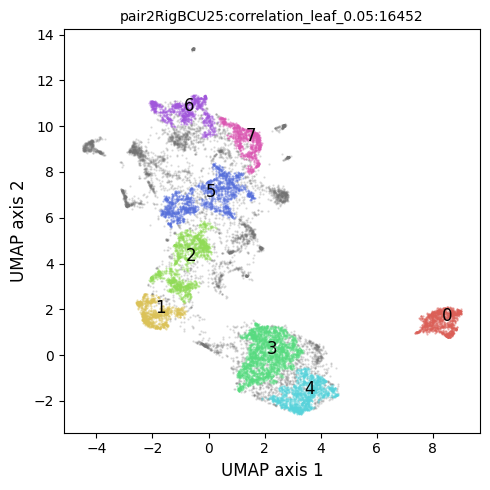

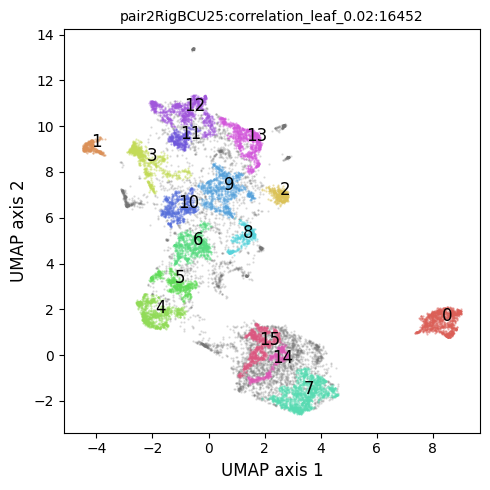

In [30]:
# loop through birds
for bi in range(1, len(birdIDs)):
# for bi in range(1):
    bd = birdIDs[bi]
    # save to a separate folder
    fd_save = os.path.join(fd_data, bd, 'UMAPonVAE2', sylStr)
    if not os.path.exists(fd_save):
        os.makedirs(fd_save)
    print(f'Save results to {fd_save}')
    # load VAE latent features and meta info
    fn_latent = os.path.join(fd_data, bd, 'UMAPonVAE1', sylStr, input_rn, 'latentM.csv')
    latent_m = np.loadtxt(fn_latent, delimiter=',')
    fn_info = os.path.join(fd_data, bd, 'Spectrogram2', sylStr, f'{bd}.{sylStr}.{input_rn}.info.csv')
    info = pd.read_csv(fn_info, index_col=0)
    print(latent_m.shape, info.shape)
    # add UMAP embedding to the dataframe
    embed_ori = info.copy()
    for ii in range(latent_m.shape[1]):
        embed_ori[f'vae{ii}'] = latent_m[:,ii]
    # loop through different parameters
    run_names = []
    for um in umap_metric:
        ## run UMAP 
        print(param_umap)
        print(rn)
        umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                                      metric=um, random_state=1118, verbose=True)
        res = umap_model.fit_transform(latent_m)
        
        # add umap results to the dataframe
        embed2 = embed_ori.copy()
        for jj in range(res.shape[1]):
            embed2[f'umap{jj+1}'] = res[:,jj]
            
        # loop through differnt HDBSCAN parameters
        for hs in hdbscan_selection:
            for hm in hdbscan_min_cluster:
                # give it a run name
                rn = f'{um}_{hs}_{hm}'
                run_names.append(rn)
                embed = embed2.copy()
                ## HDBSCAN clustering
                clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* hm), min_samples=param_hdbscan['min_samples'], cluster_selection_method=hs)
                # clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
                clusterer.fit(res)
                embed['hdbscan_cluster'] = clusterer.labels_
                embed['hdbscan_prob'] = clusterer.probabilities_

                # save embedding and clustering 
                fn_embed = os.path.join(fd_save, f'{bd}.{rn}.UMAPonVAE.embedding.csv')
                embed.to_csv(fn_embed)

                # what's the fraction that's not clustered
                unc_f = embed[embed['hdbscan_cluster']==-1].shape[0] / embed.shape[0]
                print(f'The fraction that are not clustered: {unc_f:.4f}')
                num_c = max(embed['hdbscan_cluster']+1)
                print(f'Total number of clusters: {num_c}')

                # color calls according to hdbscan labels
                col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan_cluster'])+1)
                # plot embedding
                fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
                for hi in range(-1, max(embed['hdbscan_cluster'])+1):
                    embed_s = embed[embed['hdbscan_cluster']==hi]
                    if hi==-1:
                        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color='#737373')
                    else:
                        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.5, color=col_long[hi])
                        # add syl label
                        ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
                ax.set_title(f'{bd}:{rn}:{embed.shape[0]}', fontsize=10)
                ax.set_xlabel('UMAP axis 1', fontsize=12)
                ax.set_ylabel('UMAP axis 2', fontsize=12)
                plt.tight_layout()
                # save fig
                fn_fig = os.path.join(fd_save, f'{bd}.{rn}.UMAPonVAE.HBBSCAN.pdf')
                fig.savefig(fn_fig)

                ## Quantify clustering tendency
                # in UMAP space
                hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
                print(f'Hopkins metric in UMAP: {hpk1:.4f}')
                # in VAE space
                hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
                print(f'Hopkins metric in VAE: {hpk2:.4f}')

                ## Quantify clustering quality with Silhoutte score
                # in UMAP space
                sil1 = silhouette_score(res, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
                print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
                # in VAE space
                sil2 = silhouette_score(latent_m, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
                print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

                # Calinski–Harabasz (CH) Index
                cah1 = calinski_harabasz_score(res, embed['hdbscan_cluster'])
                print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
                cah2 = calinski_harabasz_score(latent_m, embed['hdbscan_cluster'])
                print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

                # save data to the master data frame
                row = pd.DataFrame([{'birdID':bd, 'run_name':rn, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                                     'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])
                metrics = pd.concat([metrics, row], ignore_index=True)

In [31]:
# save the metrics
fn_metric = os.path.join(fd_save, 'UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
metrics

birdID               run_name  num_cluster  frac_unclustered  \
0   pair5RigCCU29     euclidean_eom_0.05            6          0.113124   
1   pair5RigCCU29     euclidean_eom_0.02            7          0.086274   
2   pair5RigCCU29    euclidean_leaf_0.05            7          0.154002   
3   pair5RigCCU29    euclidean_leaf_0.02           18          0.366308   
4   pair5RigCCU29        cosine_eom_0.05            2          0.009725   
5   pair5RigCCU29        cosine_eom_0.02            2          0.009725   
6   pair5RigCCU29       cosine_leaf_0.05            7          0.098451   
7   pair5RigCCU29       cosine_leaf_0.02           16          0.271730   
8   pair5RigCCU29   correlation_eom_0.05            2          0.003270   
9   pair5RigCCU29   correlation_eom_0.02            2          0.003270   
10  pair5RigCCU29  correlation_leaf_0.05            8          0.225602   
11  pair5RigCCU29  correlation_leaf_0.02           15          0.354776   
12  pair4RigACU68     euclidean_eom_0.05            6          0.188674   
13  pair4RigACU68     euclidean_eom_0.02           14          0.113369   
14  pair4RigACU68    euclidean_leaf_0.05            7          0.242718   
15  pair4RigACU68    euclidean_leaf_0.02           17          0.146896   
16  pair4RigACU68        cosine_eom_0.05            2          0.029924   
17  pair4RigACU68        cosine_eom_0.02            4          0.000000   
18  pair4RigACU68       cosine_leaf_0.05            6          0.217415   
19  pair4RigACU68       cosine_leaf_0.02           19          0.262328   
20  pair4RigACU68   correlation_eom_0.05            3          0.046426   
21  pair4RigACU68   correlation_eom_0.02           13          0.158640   
22  pair4RigACU68  correlation_leaf_0.05            6          0.343684   
23  pair4RigACU68  correlation_leaf_0.02           18          0.246431   
24  pair4RigBCU53     euclidean_eom_0.05            5          0.203903   
25  pair4RigBCU53     euclidean_eom_0.02            8          0.144251   
26  pair4RigBCU53    euclidean_leaf_0.05            6          0.358343   
27  pair4RigBCU53    euclidean_leaf_0.02           15          0.292145   
28  pair4RigBCU53        cosine_eom_0.05            4          0.017661   
29  pair4RigBCU53        cosine_eom_0.02           15          0.143078   
30  pair4RigBCU53       cosine_leaf_0.05           10          0.212857   
31  pair4RigBCU53       cosine_leaf_0.02           17          0.183278   
32  pair4RigBCU53   correlation_eom_0.05            4          0.017229   
33  pair4RigBCU53   correlation_eom_0.02           13          0.082747   
34  pair4RigBCU53  correlation_leaf_0.05            9          0.206558   
35  pair4RigBCU53  correlation_leaf_0.02           19          0.243423   
36  pair2RigBCU25     euclidean_eom_0.05            3          0.005835   
37  pair2RigBCU25     euclidean_eom_0.02            4          0.006139   
38  pair2RigBCU25    euclidean_leaf_0.05            6          0.194748   
39  pair2RigBCU25    euclidean_leaf_0.02           15          0.361050   
40  pair2RigBCU25        cosine_eom_0.05            3          0.011792   
41  pair2RigBCU25        cosine_eom_0.02           12          0.127948   
42  pair2RigBCU25       cosine_leaf_0.05            7          0.306650   
43  pair2RigBCU25       cosine_leaf_0.02           16          0.284464   
44  pair2RigBCU25   correlation_eom_0.05            3          0.006018   
45  pair2RigBCU25   correlation_eom_0.02            4          0.006261   
46  pair2RigBCU25  correlation_leaf_0.05            8          0.338500   
47  pair2RigBCU25  correlation_leaf_0.02           16          0.281060   

                                      cluster_persist  hopkins_umap  \
0   [0.15763438657619475, 0.318731627070003, 0.384...      0.985925   
1   [0.23798264041730022, 0.12864856138584702, 0.2...      0.985925   
2   [0.318731627070003, 0.3840965363113202, 0.3310...      0.985925   
3   [0.23798264041730022, 0.428141927515354, 0.215.

## 3. Plot summary metrics

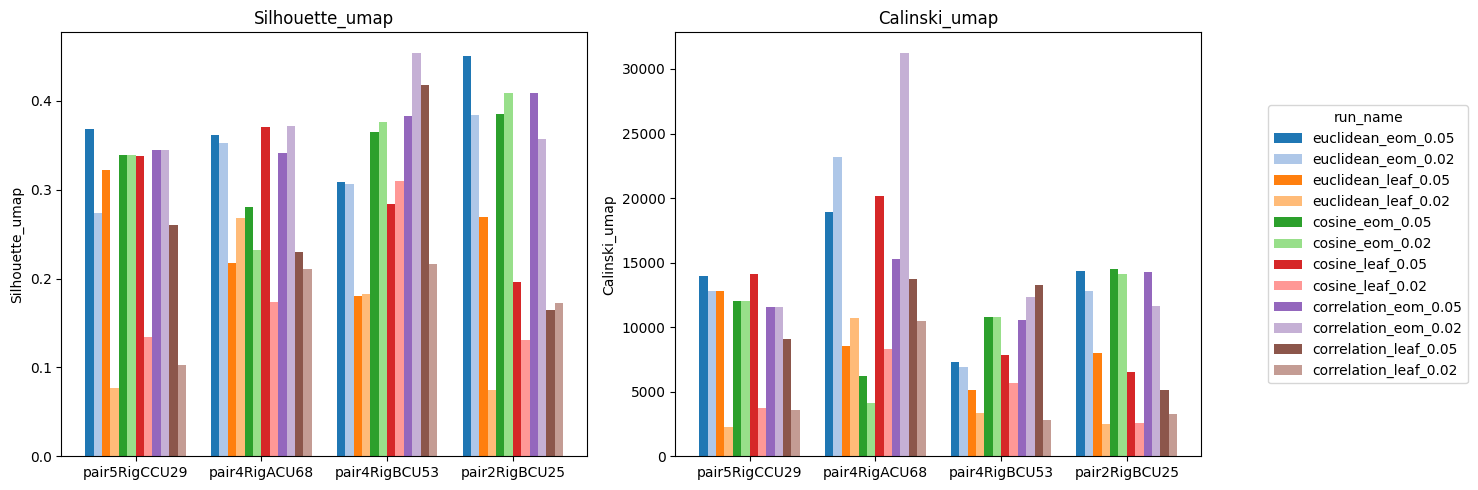

In [32]:
bird_ids = birdIDs
cmap = plt.get_cmap('tab20')
col_list = [cmap(i) for i in range(len(run_names))]
run_name_to_color = {run: col_list[i] for i, run in enumerate(run_names)}

# Setup
fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 0.3]})
metrics_to_plot = ['silhouette_umap', 'calinski_umap']
width = 0.8 / len(run_names)
x = np.arange(len(bird_ids))

# Plot loop
for ax, metric in zip(axes[:2], metrics_to_plot):
    for i, run in enumerate(run_names):
        vals = [
            metrics.loc[(metrics['birdID'] == bird) & (metrics['run_name'] == run), metric].values[0]
            if not metrics[(metrics['birdID'] == bird) & (metrics['run_name'] == run)].empty else np.nan
            for bird in bird_ids
        ]
        ax.bar(x + i * width, vals, width, label=run, color=run_name_to_color[run])
    ax.set_title(metric.capitalize())
    ax.set_xticks(x + width * (len(run_names) - 1) / 2)
    ax.set_xticklabels(bird_ids)
    ax.set_ylabel(metric.capitalize())

# Legend in third panel
axes[2].axis('off')  # Hide axis
handles, labels = axes[0].get_legend_handles_labels()
axes[2].legend(handles, labels, title='run_name', loc='center')

plt.tight_layout()
plt.show()

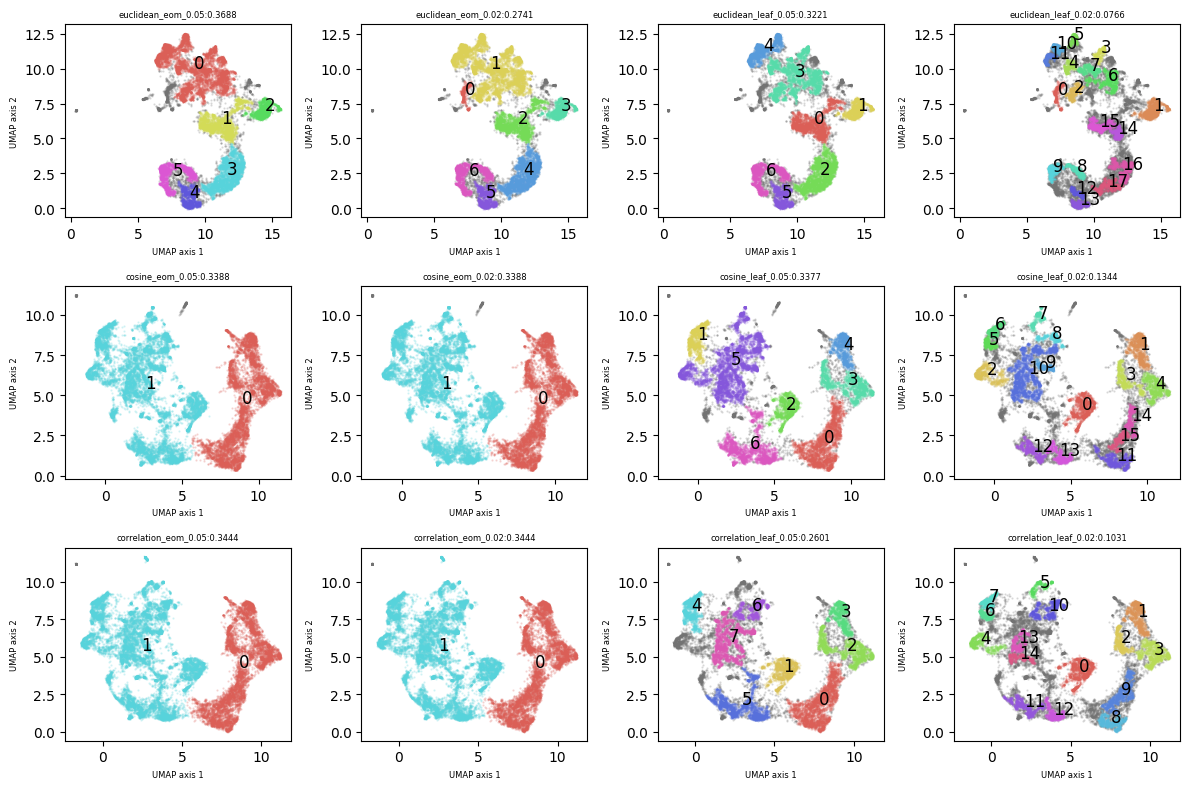

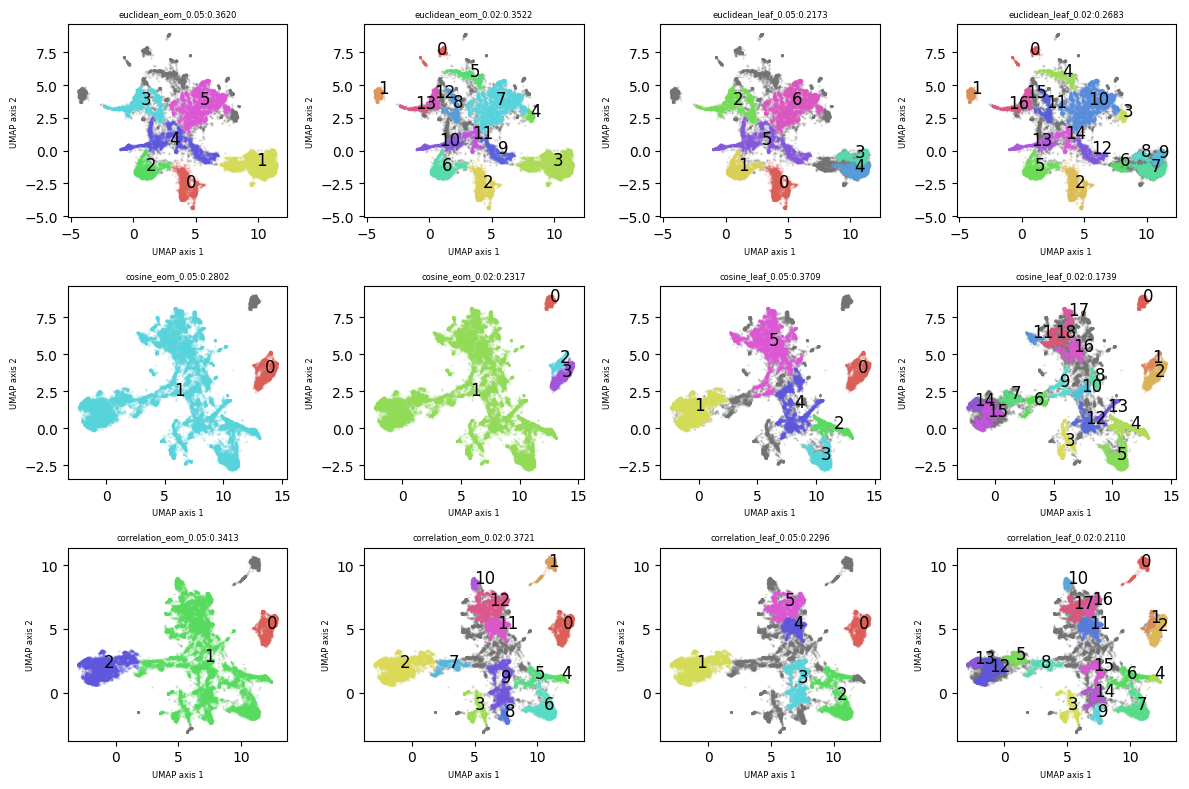

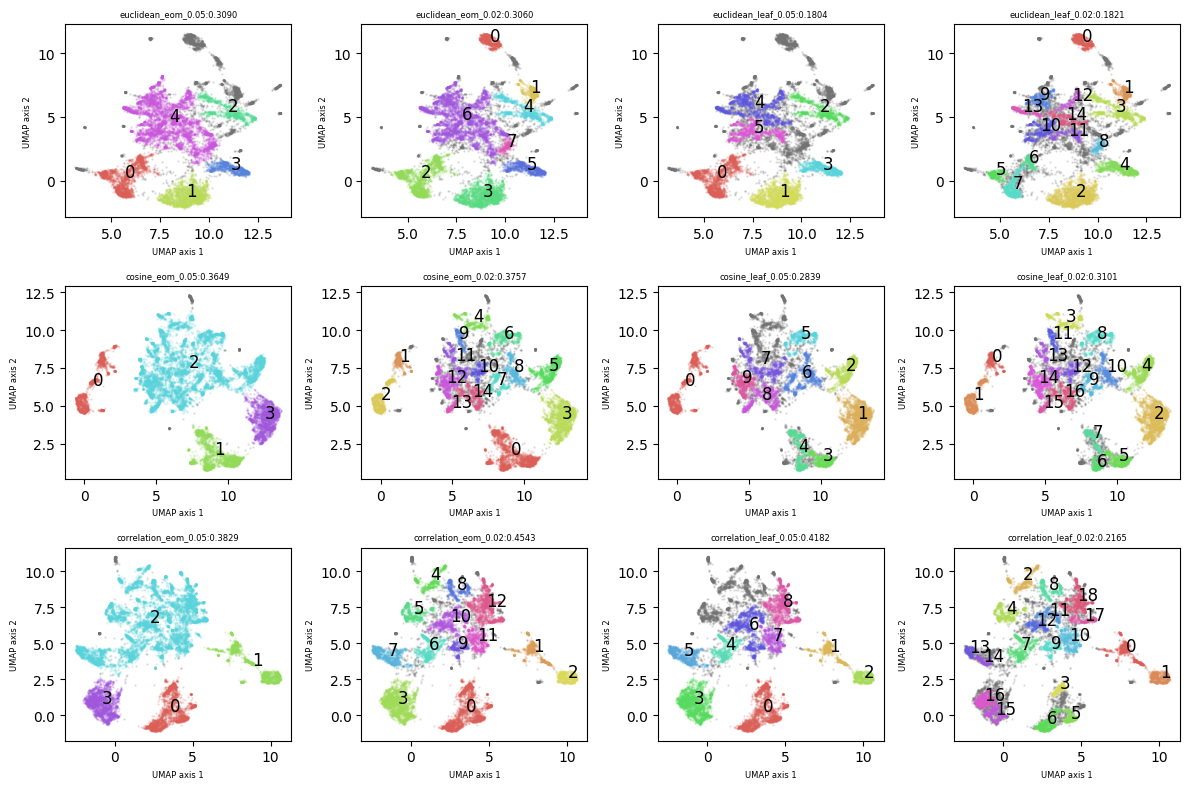

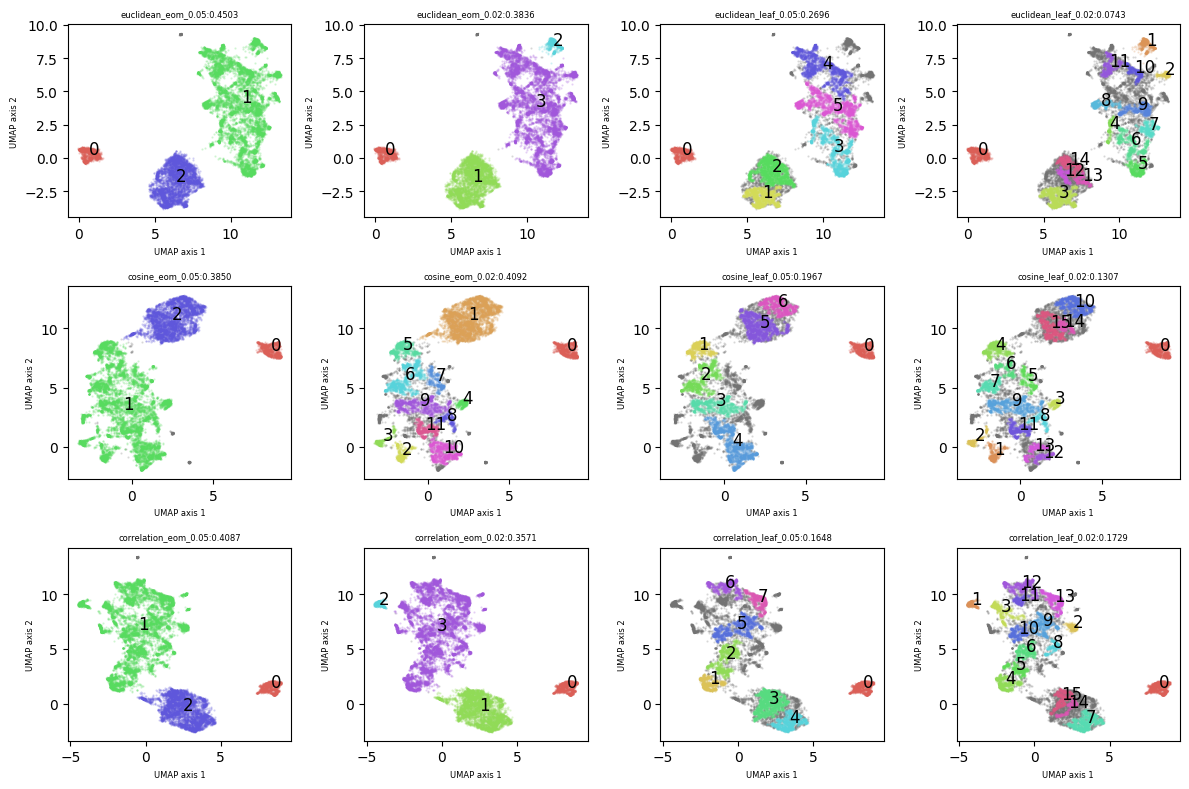

In [36]:
# Combine the HDBSCAN clustering plot
# bi = 0
for bi in range(len(birdIDs)):
# for bi in range(1):
    bd = birdIDs[bi]
    # one figure for each bird
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=[12, 8])

    for ri in range(len(run_names)):
        rn = run_names[ri]
        fd_save = os.path.join(fd_data, bd, 'UMAPonVAE2', sylStr)
        fn_embed = os.path.join(fd_save, f'{bd}.{rn}.UMAPonVAE.embedding.csv')
        embed = pd.read_csv(fn_embed, index_col=0)

        plot_i = ri//4
        plot_j = ri%4
        ax = axes[plot_i][plot_j]
        # color calls according to hdbscan labels
        col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan_cluster'])+1)
        # plot embedding
        for hi in range(-1, max(embed['hdbscan_cluster'])+1):
            embed_s = embed[embed['hdbscan_cluster']==hi]
            if hi==-1:
                ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color='#737373')
            else:
                ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color=col_long[hi])
                # add syl label
                ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
        sil = metrics.loc[(metrics['birdID'] == bd) & (metrics['run_name'] == rn), 'silhouette_umap'].iloc[0]
        ax.set_title(f'{rn}:{sil:.4f}', fontsize=6)
        ax.set_xlabel('UMAP axis 1', fontsize=6)
        ax.set_ylabel('UMAP axis 2', fontsize=6)
    plt.tight_layout()
    # save plot
    fn_fig = os.path.join(fd_save, f'{bd}.HDBSCANcomb.pdf')
    fig.savefig(fn_fig)